# DOREMUS - DBPEDIA ARTISTS MATCHING

In [463]:
import json
import csv
import sys
from os import listdir
from os.path import isfile, join
import queue
import threading
import urllib.request, urllib.error, urllib.parse
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', -1)

## GETTING DOREMUS ARTIST DATA

<div class="alert alert-success">
The first step to match Doremus and Dbpedia artists is to query Doremus endpoint about all artists; for every artist we want to know the name, the birth and the death year. To get this informations we'll use the query written below. Actually we'll retrieve also the dbpedia artist associated with the Doremus instance. In fact for some artists, the link with Dbpedia is already present. We'll save the query output in a csv file called "Artists_Doremus.csv".
<pre>
```
select $uri_doremus (group_concat( distinct $id_doremus;separator="|||") as $id_doremus) (group_concat(distinct $name_doremus;separator="|||") as $name_doremus) 
(group_concat(distinct $born_year;separator="|||") as $born_year) (group_concat( distinct $death_year;separator="|||") as $death_year) (group_concat(distinct $dbpedia;separator="|||") as $dbpedia) 
where {
$uri_doremus foaf:name $name_doremus.
$uri_doremus ecrm:P131_is_identified_by $id_doremus.
$uri_doremus a ecrm:E21_Person.
$activity ecrm:P14_carried_out_by $uri_doremus.
OPTIONAL{$uri_doremus owl:sameAs $dbpedia.
FILTER (strStarts(str($dbpedia), 'http://dbpedia.org/resource/'))}
OPTIONAL{$uri_doremus ecrm:P98i_was_born $born_year}
OPTIONAL{$uri_doremus ecrm:P100i_died_in $death_year}
} 
group by $uri_doremus
order by $name_doremus
```
</pre>


</div>


In [455]:
pd.read_csv('Artists_Doremus.csv').head()

,uri_doremus,artist_file,id_doremus,name_doremus,born_year,death_year,dbpedia
0,http://data.doremus.org/artist/bdd0ec9b-5b5b-37e1-9beb-32b5b43dd2bd,bdd0ec9b-5b5b-37e1-9beb-32b5b43dd2bd.json,"Posse, Wilhelm",Wilhelm Posse,NaN,NaN,NaN
1,http://data.doremus.org/artist/ec86d614-972c-397a-8ac1-cfeb5615b185,ec86d614-972c-397a-8ac1-cfeb5615b185.json,"Rousée, Jean",Jean Rousée,NaN,NaN,NaN
2,http://data.doremus.org/artist/c842920a-581d-3673-a123-edc385c7857c,c842920a-581d-3673-a123-edc385c7857c.json,"Gaudio, Bob (1942)",Bob Gaudio,1942,NaN,http://dbpedia.org/resource/Bob_Gaudio
3,http://data.doremus.org/artist/70a82bd5-18b8-3f71-8bca-b8c7905ae274,70a82bd5-18b8-3f71-8bca-b8c7905ae274.json,"Lapointe, Jean (1935)",Jean Lapointe,1935,NaN,NaN
4,http://data.doremus.org/artist/231cf6c9-7d32-3c0b-bf96-8a2bfadb6efe,231cf6c9-7d32-3c0b-bf96-8a2bfadb6efe.json,"Delabre, Christophe",Christophe Delabre,NaN,NaN,NaN


<div class="alert alert-success">
Here there are some samples of results that we have got performing the query. Below we'll count the number of Doremus artist for which a Dbpedia sameAs is already present.
</div>

In [460]:
doremus_df = pd.read_csv('Artists_Doremus.csv')
already_present_link = len(doremus_df['dbpedia'].drop_duplicates())
print("Total number of artists: ",len(doremus_df))
print("Number of already present matching: ",already_present_link)
print("Percentage of already present matching: ",already_present_link*100/len(doremus_df),'%')

Total number of artists:  16596
Number of already present matching:  3565
Percentage of already present matching:  21.481079778259822 %


<div class="alert alert-success">
As we can see around 20% of Doremus artist have a Dbpedia reference; we'll use this set to evaluate the quelity of our matchings.
<br>
<br>
The second step was to retrieve the matched entities by Elastic Search. For every Doremus artist we performed 2 queries:
<ol>
  <li>GET dbpedia201510/_search?q=<strong>*NAME_DOREMUS*</strong></li>
  <li>GET dbpedia201510/_search?q=<strong>*ID_DOREMUS*</strong></li>
</ol>
<br>
The ES returns also a score, associated with every entity; the first time we perfomed the matching, we have considered this; however we have noted that it drives to bad results. So we have preferred to not consider it and to score every returned entity using the method that we'll describe below.
</div>

## QUERYING ELASTIC SEARCH

In [112]:
def getQueryResponse(query,endpointURL='http://dbpedia.org/sparql'):
    escapedQuery = urllib.parse.quote(query)
    requestURL = endpointURL + "?query=" + escapedQuery +"&format=CSV"
    try:
        request = urllib.request.Request(requestURL)
        result = urllib.request.urlopen(request)
        return result
    except:
        raise Exception


In [ ]:
!rm -rf all_matched
!mkdir all_matched

In [88]:
def retrieveElasticResults(arr_strings,storage_file):
    resources = []
    for s in arr_strings:
        url = 'http://3cixty.eurecom.fr/es/dbpedia201510/_search?q='+urllib.parse.quote(s)
        req = urllib.request.Request(url)
        try:
            out = urllib.request.urlopen(req)
            d = out.read().decode('utf8')
            # returned data is JSON
            array_sources = json.loads(d)['hits']['hits']
            for link in array_sources:
                resource = link['_source']['link']
                if resource not in resources:
                    resources.append(resource)
        except urllib.error.HTTPError as err:
            if err.code == 400:
                pass
            else:
                raise  
    return resources


In [89]:
trace = 0
doremus_elastic_search_link = []

In [ ]:
with open('Artists_Doremus.csv', 'r') as f:
    reader = csv.reader(f)
    count = 0
    for row in reader:
        if count>trace:
            uri_doremus = row[0]
            id_doremus = row[2].split('|||')
            name_doremus = row[3].split('|||')
            storage_file = row[1]
            born_year = row[4]
            if born_year  == '':
                born_year = np.nan
            else:
                born_year = tuple([b for b in born_year.split('|||')])
            death_year = row[5]
            if death_year  == '':
                death_year = np.nan
            else:
                death_year = tuple([d for d in death_year.split('|||')])
            names_doremus = tuple(set(name_doremus+id_doremus))
            
            resources = retrieveElasticResults(list(names_doremus),storage_file)
            for uri in resources:
                doremus_elastic_search_link.append([uri_doremus,names_doremus,born_year,death_year,uri])
            trace += 1
        if count % 100 == 0:
            print(count)
        count += 1

In [91]:
columns=['uri_doremus','names_doremus','born_year_doremus','death_year_doremus','resource']
doremus_elastic_search_link_df = pd.DataFrame(doremus_elastic_search_link,columns=columns).drop_duplicates()

In [111]:
doremus_elastic_search_link_df.to_pickle('doremus_elastic_search_link_df')

In [461]:
doremus_elastic_search_link_df.head()

,uri_doremus,names_doremus,born_year_doremus,death_year_doremus,resource
0,http://data.doremus.org/artist/bdd0ec9b-5b5b-37e1-9beb-32b5b43dd2bd,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/List_of_Posse_Scholars_school_partnerships
1,http://data.doremus.org/artist/bdd0ec9b-5b5b-37e1-9beb-32b5b43dd2bd,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/Posse_comitatus_(common_law)
2,http://data.doremus.org/artist/bdd0ec9b-5b5b-37e1-9beb-32b5b43dd2bd,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/L.A._Posse
3,http://data.doremus.org/artist/bdd0ec9b-5b5b-37e1-9beb-32b5b43dd2bd,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/Konstantin_Posse
4,http://data.doremus.org/artist/bdd0ec9b-5b5b-37e1-9beb-32b5b43dd2bd,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/Martín_Posse


<div class="alert alert-success">
After querying the elastic search we got a csv table; same row samples are rapresented above. Every line is formed by a possible match Doremus artist - Dbpedia artist. We can note that there are many possible matchings for a Doremus artistt. Our goal is to understand which is, if there is, the exact one. 
<br>
For the moment, we have only the information associated to Doremus artists as label,birh, death. On the other side instead we have only a possible matching URI. We need to query Dbpedia SPARQL endpoint to get these informations:
  <ol>
  <li> the list of associated labels/names </li>
  <li> the birth year </li>
  <li> the death year </li>
  <li> the related categories  </li>
  </ol> 

</div>

## ENRICH ES RESOURCES 1 - GETTING LABELS

<div class="alert alert-success">
To get the labels we checked both `rdfs:labels` and `foaf:name`. In addiotion we took the labels of every language to have more chances to match the label with the Doremus one. Actually these is the real sense to query Dbpedia endpoint; in fact also hte ES retrieves the linked labels, they are not for every language.
<pre>
```
{
{
 values ?resource { <STR_TO_SUB> }
 ?resource rdfs:label ?resource_label
}
UNION
{
 values ?resource { <STR_TO_SUB> }
 ?resource foaf:name ?resource_label
}
}
```
</pre>


</div>

In [116]:
all_elastic_resources_distinct = list(doremus_elastic_search_link_df['resource'].drop_duplicates())

In [113]:
int_query = '''{
{
 values ?resource { <STR_TO_SUB> }
 ?resource rdfs:label ?resource_label
}
UNION
{
 values ?resource { <STR_TO_SUB> }
 ?resource foaf:name ?resource_label
}
}'''

basic_query = '''
select ?resource ?resource_label
where {

STR_TO_SUB

}'''

In [114]:
artist_label_df = pd.DataFrame([],columns=['resource','resource_label'])
trace = 0

In [120]:
start = trace
end = len(all_elastic_resources_distinct)
step = 1
for i in range(start,end,step):
    if i % 350 == 0:
        print(i)
    core_query_arr = [int_query.replace('STR_TO_SUB',all_elastic_resources_distinct[j]) for j in range(i,i+step)]
    core_query = '\nUNION\n'.join(core_query_arr)
    query = basic_query.replace('STR_TO_SUB',core_query)
    res = pd.read_csv(getQueryResponse(query,endpointURL='http://dbpedia.org/sparql'))
    artist_label_df=artist_label_df.append(res,ignore_index=True)
    trace += step

In [124]:
artist_label_df = artist_label_df.drop_duplicates()

In [126]:
artist_label_df1 = (artist_label_df
                         .groupby('resource')['resource_label']
                         .apply(tuple)
                         .reset_index(name='resource_label')
                        )

In [129]:
doremus_elastic_search_link_with_labels = (
    pd.merge(
    doremus_elastic_search_link_df,
    artist_label_df1,
    on='resource',
    how='inner')
    )

In [462]:
doremus_elastic_search_link_with_labels.head()

,uri_doremus,names_doremus,born_year_doremus,death_year_doremus,resource,resource_label
0,http://data.doremus.org/artist/bdd0ec9b-5b5b-37e1-9beb-32b5b43dd2bd,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/List_of_Posse_Scholars_school_partnerships,"(List of Posse Scholars school partnerships,)"
1,http://data.doremus.org/artist/bdd0ec9b-5b5b-37e1-9beb-32b5b43dd2bd,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/Posse_comitatus_(common_law),"(Posse comitatus (common law),)"
2,http://data.doremus.org/artist/bdd0ec9b-5b5b-37e1-9beb-32b5b43dd2bd,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/L.A._Posse,"(L.A. Posse,)"
3,http://data.doremus.org/artist/bdd0ec9b-5b5b-37e1-9beb-32b5b43dd2bd,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/Konstantin_Posse,"(Поссе, Константин Александрович, Konstantin Posse, Posse, Konstantin)"
4,http://data.doremus.org/artist/971ec68f-5fe1-3dec-b9c0-4e8212227275,"(Dimitrescu, Constantin (1847-1928), Constantin Dimitrescu)","(1847,)","(1928,)",http://dbpedia.org/resource/Konstantin_Posse,"(Поссе, Константин Александрович, Konstantin Posse, Posse, Konstantin)"


## ENRICH ES RESOURCES 1 - GETTING BIRTH AND DEATH YEARS

<div class="alert alert-success">
After retrieving the labels we want to retrieve the birth and the death. To get these info we'll query DBpedia for each year. For example, considering the year 1998:
<pre>
```
{
values ?birth_year { 1998 }
{?resource dct:subject dbc:1998_births.}
UNION
{?resource dbo:birthDate|dbo:birthYear|dbp:dateOfBirth ?birth.
filter regex (str(xsd:date(?birth)),"^1998")}
}
```
</pre>
Looking at the query, you can note that to get the year information we have consider different properties because the most of the time the birth year is written as object of the property `dct:subject`. Actually it's part of the object, e.g. `dbc:1998_births`. However there are cases in which the year is saved as object of other properties as `dbo:birthDate`,`dbo:birthYear`,`dbp:dateOfBirth`. The same considerations could be done for the death year.
<br>
Performing a query for every year asking about all people borned in this year is faster than the inverse: performing a query for every resource asking about the death and the birth year. In fact we have a lot of entities retrieved by the ES queries; instead we have only about 2000 years from 0 to 2017.
We used the first approach joining the result with the ES entities at the end.
<br>
To be faster, we'll perform a query for every 10 years, using the UNION operator.
You can see below all the implementation about what we've described.
</div>

In [136]:
internal_years_query = '''
{
values ?birth_year { YEAR }
{?resource dct:subject dbc:YEAR_births.}
UNION
{?resource dbo:birthDate|dbo:birthYear|dbp:dateOfBirth ?birth.
filter regex (str(xsd:date(?birth)),"^YYYY")}
}
'''

In [137]:
years_birth_query = '''
select distinct ?resource ?birth_year where{
STR_TO_SUB
}
offset OFFSET
limit 10000
'''
artist_years_birth_df = pd.DataFrame([],columns=['resource','birth_year'])
start = 0

In [ ]:
step = 10
for i in range(start,2018,step):
    if i % 10 == 0:
        print (i)
    n = 10000
    start = i
    offset = 0
    int_queries = 'UNION\n'.join([internal_years_query.replace('YEAR',str(j)).replace('YYYY',str(j).zfill(4)) for j in range(i,i+step)])
    while n == 10000:
        query = years_birth_query.replace('STR_TO_SUB',int_queries).replace('OFFSET',str(offset))
        #print(query)
        res = pd.read_csv(getQueryResponse(query,endpointURL='http://dbpedia.org/sparql'))
        if len(res) > 0:
            artist_years_birth_df=artist_years_birth_df.append(res,ignore_index=True).drop_duplicates()
        if len(res) != 10000:
            n = 0
        offset += 10000

In [139]:
artist_years_birth_df = (artist_years_birth_df
                         .groupby('resource')['birth_year']
                         .apply(tuple)
                         .reset_index(name='birth_year')
                        )
artist_years_birth_df.drop_duplicates().to_pickle('artist_years_birth_df')

In [140]:
artist_years_birth_df = pd.read_pickle('artist_years_birth_df')

In [142]:
internal_years_query = '''
{
values ?death_year { YEAR }
{?resource dct:subject dbc:YEAR_deaths.}
UNION
{?resource dbo:deathDate|dbo:deathYear|dbp:dateOfDeath ?death.
filter regex (str(xsd:date(?death)),"^YYYY")}
}
'''

In [148]:
years_death_query = '''
select distinct ?resource ?death_year where{
STR_TO_SUB
}
offset OFFSET
limit 10000
'''
artist_years_death_df = pd.DataFrame([],columns=['resource','death_year'])
start = 0 

step = 10
for i in range(start,2018,step):
    if i % 10 == 0:
        print (i)
    n = 10000
    start = i
    offset = 0
    int_queries = 'UNION\n'.join([internal_years_query.replace('YEAR',str(j)).replace('YYYY',str(j).zfill(4)) for j in range(i,i+step)])
    while n == 10000:
        formatted_year = str(i).zfill(4)
        query = years_death_query.replace('STR_TO_SUB',int_queries).replace('OFFSET',str(offset))
        res = pd.read_csv(getQueryResponse(query,endpointURL='http://dbpedia.org/sparql'))
        if len(res) > 0:
            artist_years_death_df=artist_years_death_df.append(res,ignore_index=True).drop_duplicates()
        if len(res) != 10000:
            n = 0
        offset += 10000

In [150]:
artist_years_death_df = (artist_years_death_df
                         .groupby('resource')['death_year']
                         .apply(tuple)
                         .reset_index(name='death_year')
                        )
artist_years_death_df.drop_duplicates().to_pickle('artist_years_death_df')

In [151]:
artist_years_death_df = pd.read_pickle('artist_years_death_df')

In [154]:
doremus_elastic_search_link_birth=(pd.merge(
    doremus_elastic_search_link_with_labels,
    artist_years_birth_df,
    on='resource',
    how='left')
    )
doremus_elastic_search_years=(pd.merge(
    doremus_elastic_search_link_birth,
    artist_years_death_df,
    on='resource',
    how='left')
    )

In [ ]:
doremus_elastic_search_years.head()

## ENRICH ES RESOURCES 1 - GETTING CATEGORIES

<div class="alert alert-success">
We need also to check that the entities retrieved by the Elastic Search are composers or musicians or arists or at least people. So it's necessary to get the types of every resources, in particular the ones linked whit the idea of composer.
When we'll perform the final scoring we'll assign higher scores more specific the category is.
<br>
For every resource, we'll perform this query:
<pre>
```
{
 values ?uri_doremus { URI_RESOURCE }
 ?uri_doremus rdf:type $type
 filter (?type=<http://schema.org/Person>||?type=<http://xmlns.com/foaf/0.1/Person>||?type=<http://dbpedia.org/ontology/Person>||?type=<http://dbpedia.org/class/yago/Person100007846>||?type=<http://dbpedia.org/class/yago/Creator109614315>||?type=<http://dbpedia.org/class/yago/Artist109812338>||?type=<http://dbpedia.org/class/yago/Musician110339966>||?type=<http://dbpedia.org/class/yago/Composer109947232>)
}
UNION
{
 values ?type {<http://dbpedia.org/class/yago/Composer109947232>}
 values ?uri_doremus { URI_RESOURCE }
 ?uri_doremus dc:description|dbo:occupation|dct:subject ?t
 filter regex(?t,"composer","i")
}
```
</pre>

Also this time we'll group more queries together using the UNION operator to be faster.

</div>

In [155]:
all_elastic_resources_distinct = list(doremus_elastic_search_years['resource'].drop_duplicates())

In [156]:
int_query = '''{
{
 values ?resource { <STR_TO_SUB> }
 ?resource rdf:type $type
 filter (?type=<http://schema.org/Person>||?type=<http://xmlns.com/foaf/0.1/Person>||?type=<http://dbpedia.org/ontology/Person>||?type=<http://dbpedia.org/class/yago/Person100007846>||?type=<http://dbpedia.org/class/yago/Creator109614315>||?type=<http://dbpedia.org/class/yago/Artist109812338>||?type=<http://dbpedia.org/class/yago/Musician110339966>||?type=<http://dbpedia.org/class/yago/Composer109947232>)
}
UNION
{
 values ?type {<http://dbpedia.org/class/yago/Composer109947232>}
 values ?resource { <STR_TO_SUB> }
 ?resource dc:description|dbo:occupation|dct:subject ?t
 filter regex(?t,"composer","i")
}
}'''

basic_query = '''
select $resource $type
where {

STR_TO_SUB

}'''

In [157]:
artist_category_df = pd.DataFrame([],columns=['resource','type'])
trace = 0

In [167]:
start = trace
end = len(all_elastic_resources_distinct)
step = 1
for i in range(start,end,step):
    if i % 100 == 0:
        print(i)
    core_query_arr = [int_query.replace('STR_TO_SUB',all_elastic_resources_distinct[j]) for j in range(i,i+step)]
    core_query = '\nUNION\n'.join(core_query_arr)
    query = basic_query.replace('STR_TO_SUB',core_query)
    res = pd.read_csv(getQueryResponse(query,endpointURL='http://dbpedia.org/sparql'))
    artist_category_df=artist_category_df.append(res,ignore_index=True)
    trace += step
    

In [168]:
artist_category_df=artist_category_df.drop_duplicates()
artist_category_df.columns = ['resource','categories']

In [169]:
artist_category_df.to_pickle('artist_category_df')

In [171]:
artist_category_df_grouped = artist_category_df.groupby('resource')['categories'].apply(tuple).reset_index(name="categories")

In [172]:
doremus_dbpedia_link_df=pd.merge(doremus_elastic_search_years,artist_category_df_grouped, on='resource', how='left')

In [177]:
doremus_dbpedia_link_df.to_pickle('doremus_dbpedia_link_df')

In [970]:
doremus_dbpedia_link_df= pd.read_pickle('doremus_dbpedia_link_df')

In [257]:
doremus_dbpedia_link_df.head(50)

,uri_doremus,names_doremus,born_year_doremus,death_year_doremus,resource,resource_label,birth_year,death_year,categories
0,http://data.doremus.org/artist/bdd0ec9b-5b5b-3...,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/List_of_Posse_Scho...,"(List of Posse Scholars school partnerships,)",NaN,NaN,NaN
1,http://data.doremus.org/artist/bdd0ec9b-5b5b-3...,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/Posse_comitatus_(c...,"(Posse comitatus (common law),)",NaN,NaN,NaN
2,http://data.doremus.org/artist/bdd0ec9b-5b5b-3...,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/L.A._Posse,"(L.A. Posse,)",NaN,NaN,(http://dbpedia.org/class/yago/Artist109812338...
3,http://data.doremus.org/artist/bdd0ec9b-5b5b-3...,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/Konstantin_Posse,"(Поссе, Константин Александрович, Konstantin P...","(1847,)","(1928,)","(http://schema.org/Person, http://xmlns.com/fo..."
4,http://data.doremus.org/artist/971ec68f-5fe1-3...,"(Dimitrescu, Constantin (1847-1928), Constanti...","(1847,)","(1928,)",http://dbpedia.org/resource/Konstantin_Posse,"(Поссе, Константин Александрович, Konstantin P...","(1847,)","(1928,)","(http://schema.org/Person, http://xmlns.com/fo..."
5,http://data.doremus.org/artist/bdd0ec9b-5b5b-3...,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/Martín_Posse,"(Martín Posse, Martín Andrés Posse Paz, Posse,...","(1975,)",NaN,"(http://schema.org/Person, http://xmlns.com/fo..."
6,http://data.doremus.org/artist/bdd0ec9b-5b5b-3...,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/Posse:_Thirteen_Ag...,"(Posse: Thirteen Against One,)",NaN,NaN,NaN
7,http://data.doremus.org/artist/bdd0ec9b-5b5b-3...,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,"http://dbpedia.org/resource/Posse,_Goiás","(Posse (Goiás), Posse, Goiás, Posse, Поси, 波塞 ...",NaN,NaN,NaN
8,http://data.doremus.org/artist/bdd0ec9b-5b5b-3...,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/Knut_Posse,"(Knut Posse, Поссе, Кнут, Posse, Knut)",NaN,"(1500,)","(http://schema.org/Person, http://xmlns.com/fo..."
9,http://data.doremus.org/artist/bdd0ec9b-5b5b-3...,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/Posse_Comitatus_(o...,"(Posse Comitatus (organization),)",NaN,NaN,NaN


## CLEANING DOREMUS YEARS

<div class="alert alert-success">
Now we have all data to compute the link Dbpedia and Doremus; however we have to perform a cleaning step on the years. In fact we have dirty data both in Doremus. As you can see looking at the table above, in Doremus there are some years not very precise as "18..". We deduce that this probably means that we know the century in which the artist is born but not the specific year; we'll preserve this information because it could be useful also it is more generic. However there are also worst data. For example we noted that sometimes in the year filed there are informations that don't seem to be linked with a date; for example we founded in the birth field "composer". In these cases we deleted the year informaions. 
</div>

In [283]:
import itertools
birth_doremus_years = list(doremus_dbpedia_link_df[doremus_dbpedia_link_df['born_year_doremus'].notnull()]['born_year_doremus'])
birth_doremus_years = list(itertools.chain.from_iterable(birth_doremus_years))
bad_birth_doremus_years = set([x for x in birth_doremus_years if re.search('[a-z]', x)])
print("all Doremus bad birth years:",bad_birth_doremus_years)

all Doremus bad birth years: {'ca1500', 'compositeur', 'ca 1720', 'ca 1400', 'ca 1750', 'ca 1430', 'ca1750', 'ca1761', 'ca 1580', 'ca 1736', 'ca1551.', 'ca 1555', 'fl 1658', 'ca 1500', 'ca 1700', 'ca 1516', 'ca 1550', 'ca 1760', 'ca 1706', 'vers 1550', 'ca 1570'}


In [285]:
birth_doremus_years = list(doremus_dbpedia_link_df[doremus_dbpedia_link_df['death_year_doremus'].notnull()]['death_year_doremus'])
birth_doremus_years = list(itertools.chain.from_iterable(birth_doremus_years))
bad_birth_doremus_years = set([x for x in birth_doremus_years if re.search('[a-z]', x)])
print("all Doremus bad death years:",bad_birth_doremus_years)

all Doremus bad death years: {'ca 1783', 'ap. 1791', 'ca1721', 'ap.1692', 'ca 1960', 'après 1753', 'ca 1593', 'ca 1790', 'après 1816'}


In [287]:
def transformGeneralYearInfo(x):
    if re.search('[0-9]', x):
        if re.search('[^0-9]', x): 
            while re.search('[^0-9]', x[0]):
                x = x.replace(x[0],'')
            return -int(re.sub("[^0-9]", "0", x))
        else:
            return int(x)
    else:
        return np.nan


In [288]:
def transformField(t):
    if type(t) != float:
        return tuple([transformGeneralYearInfo(x) for x in list(t)])
    else:
        return t


In [290]:
birthyear_doremus_column = doremus_dbpedia_link_df['born_year_doremus'].apply(lambda t: transformField(t))
deathyear_doremus_column = doremus_dbpedia_link_df['death_year_doremus'].apply(lambda t: transformField(t))

In [292]:
doremus_dbpedia_link_df['born_year_doremus'] = birthyear_doremus_column
doremus_dbpedia_link_df['death_year_doremus'] = deathyear_doremus_column

In [294]:
doremus_dbpedia_link_df.head(60)

,uri_doremus,names_doremus,born_year_doremus,death_year_doremus,resource,resource_label,birth_year,death_year,categories
0,http://data.doremus.org/artist/bdd0ec9b-5b5b-3...,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/List_of_Posse_Scho...,"(List of Posse Scholars school partnerships,)",NaN,NaN,NaN
1,http://data.doremus.org/artist/bdd0ec9b-5b5b-3...,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/Posse_comitatus_(c...,"(Posse comitatus (common law),)",NaN,NaN,NaN
2,http://data.doremus.org/artist/bdd0ec9b-5b5b-3...,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/L.A._Posse,"(L.A. Posse,)",NaN,NaN,(http://dbpedia.org/class/yago/Artist109812338...
3,http://data.doremus.org/artist/bdd0ec9b-5b5b-3...,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/Konstantin_Posse,"(Поссе, Константин Александрович, Konstantin P...","(1847,)","(1928,)","(http://schema.org/Person, http://xmlns.com/fo..."
4,http://data.doremus.org/artist/971ec68f-5fe1-3...,"(Dimitrescu, Constantin (1847-1928), Constanti...","(1847,)","(1928,)",http://dbpedia.org/resource/Konstantin_Posse,"(Поссе, Константин Александрович, Konstantin P...","(1847,)","(1928,)","(http://schema.org/Person, http://xmlns.com/fo..."
5,http://data.doremus.org/artist/bdd0ec9b-5b5b-3...,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/Martín_Posse,"(Martín Posse, Martín Andrés Posse Paz, Posse,...","(1975,)",NaN,"(http://schema.org/Person, http://xmlns.com/fo..."
6,http://data.doremus.org/artist/bdd0ec9b-5b5b-3...,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/Posse:_Thirteen_Ag...,"(Posse: Thirteen Against One,)",NaN,NaN,NaN
7,http://data.doremus.org/artist/bdd0ec9b-5b5b-3...,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,"http://dbpedia.org/resource/Posse,_Goiás","(Posse (Goiás), Posse, Goiás, Posse, Поси, 波塞 ...",NaN,NaN,NaN
8,http://data.doremus.org/artist/bdd0ec9b-5b5b-3...,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/Knut_Posse,"(Knut Posse, Поссе, Кнут, Posse, Knut)",NaN,"(1500,)","(http://schema.org/Person, http://xmlns.com/fo..."
9,http://data.doremus.org/artist/bdd0ec9b-5b5b-3...,"(Wilhelm Posse, Posse, Wilhelm)",NaN,NaN,http://dbpedia.org/resource/Posse_Comitatus_(o...,"(Posse Comitatus (organization),)",NaN,NaN,NaN


## MATCHING ALGORITHM

<div class="alert alert-success">
We defined a method to score the Doremus-Dbpedia artist links. This criteria keeps into account:
<ul>
  <li><strong>The names/labels similarity</strong>: to compute it we used a Python library called "fuzzywuzzy" that uses the Levenshtein Distance to compute the string similarity; actually we deleted from the Dbpedia artists candidates the ones that present a very low label similarity with the Doremus one.</li>
  <li><strong>The year matching</strong>: for every pair Doremus artist-Dbpedia artist we check if the born year and the death year is the same. However the year informations are not always present in both Doremus and Dbpedia. So we can have different possibilities:
  <ol>
  <li> If the complete information is present on both sides and fits we assign an high score to the possible Dbpedia artist candidate. </li>
  <li> In the case in which the informations are present only on one side we assigned score 0 but we continue to consider the Dbpedia entity as a possible candidate,because we haven't enough information to say that the 2 entities are not the same.</li>
  <li>Instead, if the information is present on both sides but it's different:we delete the Dbpedia artist from the candidates. Actually we don't eliminate the candidate if the years differ for 1 or 2 years, because we have noted that, especially for the old artists, the dates are not always precise.</li>
  <li>When we have only information about the century: if the century matches we preserves the candidate assigning it a low score; if the century is different we delete the candidate.</li>
  <li> If the birth year is present on both sides and fits but the death year is not present on both sides, it could mean that the artist is not already death. To check that we basically look at the birth date and, if it is not too far from the current date, we consider the artist as still alive, and we increase the score also for the death year matching. However this score rise is less significant than when we have explicitly the same death year.  </li>
  </ol>  
  <li><strong>Finally we check the categories of the Dbpedia entity</strong>: if it is a composer we assign a high score, alternately we assign a lower score if it is only an artist, and so on. The score assignment descreases following a gaussian distribution. If the entity is not a person we assign a negative score.</li>
</ul>
Doing like this we obtain four normalized scores for label,birth,death and category. We compute a weighted sum of these score to get the final one. Actually it is not a precise weighted sum; in fact we wanted to keep into account some particular combinations; for example if the category is too generic and the label score is too low, we deleted the candidate also if the years match. We have taken this decision after some trials, noting that considering also these candidates the number of errors increases.
</div>

In [314]:
doremus_dbpedia_link_np = doremus_dbpedia_link_df.as_matrix()

In [374]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from scipy import signal

def similar(a, b,w):
    return (w*fuzz.token_sort_ratio(a, b)+(1-w)*fuzz.ratio(a,b))/100
def YearMatching(arr_years1,arr_years2):
    if type(arr_years1)==float or type(arr_years2)==float:
        return 0.0
    else:
        specific_years1 = [y for y in list(arr_years1) if y >= 0]
        specific_years2 = [y for y in list(arr_years2) if y >= 0]
        general_years1 = [y for y in list(arr_years1) if y < 0]
        #print(set(list(arr_years2)))
        #x = input()
        if set(list(specific_years1)) & set(list(specific_years2)):
            return 1.0
        else:
            diff=[abs(s1-s2) for s2 in specific_years2 for s1 in specific_years1]
            if len(diff)>0:
                if min(diff)<=2:
                    return 0.3
            if len(general_years1) > 0:
                general_years_abs1 =  [abs(g) for g in general_years1]
                arr_dist = [s-g for g in general_years_abs1 for s in specific_years2+general_years1 if s-g >= 0]
                if len(arr_dist) > 0:
                    min_dist = min(arr_dist)
                    if min_dist > 60:
                        return -1.0
                    elif min_dist > 30:
                        return 0.0
                    else:
                        return 0.1
                else:
                    return -1.0
            else:
                return -1.0
def LabelMatching(arr_str1,arr_str2):
    sim = 0.0
    for s1 in arr_str1:
        for s2 in arr_str2:
            sim = max([similar(s1, s2,0.6),sim])
            if sim == 1.0:
                return sim
    return sim

def CategoryMatching(list_categories,weight_categories,categories):
    if not type(categories)==float:
        for i in range(n-1,-1,-1):
            if set(list_categories[i]) & set(categories):
                return weight_categories[i]
    else:
        return -0.8
    
def evaluateSupposition(age):
    if age < 50:
        return 1.0
    else:
        return -(1/100)*age + 3/2
            
            

In [310]:
list_categories = ([['http://schema.org/Person',
  'http://xmlns.com/foaf/0.1/Person',
  'http://dbpedia.org/ontology/Person',
  'http://dbpedia.org/class/yago/Person100007846'],
 ['http://dbpedia.org/class/yago/Creator109614315'],
 ['http://dbpedia.org/class/yago/Artist109812338'],
 ['http://dbpedia.org/class/yago/Musician110339966'],
 ['http://dbpedia.org/class/yago/Composer109947232']])
n = len(list_categories)
weight_categories = signal.gaussian(n*2+1, std=1.3)[1:n+1]

In [311]:
w_label = 0.25
w_birth = 0.25
w_death = 0.25
w_category = 0.25

In [312]:
from datetime import date
current_year = date.today().year

In [ ]:
doremus_dbpedia_score_np= []
for i,link in enumerate(doremus_dbpedia_link_np):
    if i % 1000 == 0:
        print (i)
    doremus_uri = link[0]
    doremus_label = link[1]
    doremus_born = link[2]
    doremus_death = link[3]
    dbpedia_uri = link[4]
    dbpedia_label = link[5]
    dbpedia_born = link[6]
    dbpedia_death = link[7]
    dbpedia_category = link[8]
    score_birth = YearMatching(doremus_born,dbpedia_born)
    if not score_birth < 0.0:
        score_death_partial = YearMatching(doremus_death,dbpedia_death)
        if not score_death_partial < 0.0:
            if score_birth == 1.0:
                age = current_year - dbpedia_born[0]
                if age < 100 and score_death_partial==0.0:
                    score_death = 0.9*evaluateSupposition(age)
                    threshold_label = 0.88
                else:
                    score_death = score_death_partial
                    threshold_label = 0.65
            else:
                score_death = score_death_partial
                threshold_label = 0.65
            score_label = LabelMatching(list(doremus_label),list(dbpedia_label))
            if score_label > threshold_label:
                score_category = CategoryMatching(list_categories,weight_categories,dbpedia_category)
                if (score_category < 0.7 and score_label >= 0.9) or score_category >= 0.7:
                    score = (w_birth*score_birth + w_death*score_death + w_label*score_label + w_category*score_category) 
                    new_link = [doremus_uri,dbpedia_uri,score_label,score_birth,score_death,score_category,score]
                    doremus_dbpedia_score_np.append(new_link)
    #print(paths_filtered_with_score_np)

In [376]:
doremus_dbpedia_score = pd.DataFrame(np.array(doremus_dbpedia_score_np),columns=['doremus_uri','dbpedia_uri','score_label','score_birth','score_death','score_category','score']).drop_duplicates()

In [377]:
doremus_dbpedia_artist_final = (doremus_dbpedia_score
                                .sort_values('score', ascending=False)
                                .groupby('doremus_uri', as_index=False)
                                .first()
                                .sort_values('score', ascending=False)
                               )

In [378]:
doremus_dbpedia_artist_final = (doremus_dbpedia_artist_final
                                .sort_values('score', ascending=False)
                                .groupby('dbpedia_uri', as_index=False)
                                .first()
                                .sort_values('score', ascending=False)
                               )

## SHORT EVALUATION

<div class="alert alert-success">
The graph below shows the scores distribution; as we can see the majority of matchings seems to have score near 1 that is good; however some noise it is present; to remove it we'll cut all matchings with score lower that 0.5. 0.5 generally means that we don't have informations about the death and birth years but label matches perfectly and the DBpedia entity has an rdf:type that clearly indicates that it is a composer.
</div>

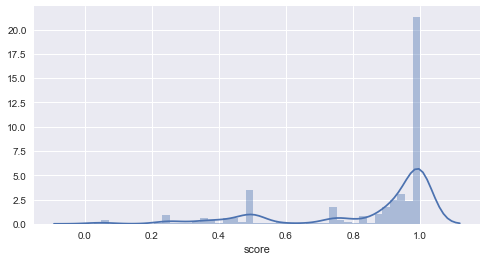

In [466]:
import seaborn as sns, numpy as np
sns.set(rc={"figure.figsize": (8, 4)}); np.random.seed(0)
x = doremus_dbpedia_artist_final['score'].astype(float)
ax = sns.distplot(x)
sns.plt.show()

In [380]:
doremus_dbpedia_artist_final = doremus_dbpedia_artist_final.sort_values('score',ascending=False)

In [381]:
doremus_dbpedia_artist_final.to_pickle("doremus_dbpedia_artist_final")

In [382]:
doremus_dbpedia_artist_final= pd.read_pickle('doremus_dbpedia_artist_final')

In [383]:
doremus_dbpedia_filtered=doremus_dbpedia_artist_final[['doremus_uri','dbpedia_uri','score']]

In [384]:
doremus_dbpedia_filtered.columns = ['uri_doremus','uri_dbpedia','rank']

In [385]:
doremus_dbpedia_filtered.to_csv('doremus_dbpedia_artists.csv',index=False)

In [386]:
doremus_dbpedia_filtered_0_5 =doremus_dbpedia_filtered[doremus_dbpedia_filtered['rank'].astype(float)>=0.5]

In [393]:
doremus_dbpedia_filtered_0_5.to_csv("5_0_doremus_dbpedia_artists.csv",index=False)

In [467]:
print("Number of matchings:",len(doremus_dbpedia_artist_final))
print("Number of matchings considerable good:",len(doremus_dbpedia_filtered_0_5))

Number of matchings: 6731
Number of matchings considerable good: 6026


<div class="alert alert-success">
We'll perform the evaluation only considering teh 6026 good matchings becuase it's really probable that the others are completly wrong.
</div>

In [ ]:
'''
columns=['uri_doremus','names_doremus','born_year_doremus','death_year_doremus','resource','resource_label']
doremus_elastic_search_link_df[['uri_doremus','names_doremus']]
eval_pd = (pd.merge
           (doremus_elastic_search_link_df[['uri_doremus','names_doremus']], doremus_dbpedia_filtered_0_5, how='right', on='uri_doremus')
           [['names_doremus','uri_dbpedia']]
          )
eval_pd.to_csv('../Dbpedia_with_Doremus_Labels.csv',index=False)
'''

In [339]:
doremus_artists = pd.read_csv("Artists_Doremus.csv")

In [340]:
doremus_artists_with_dbpedia_link = doremus_artists[doremus_artists['dbpedia'].notnull()]

In [390]:
evaluation_table= (
    pd.merge(
    doremus_dbpedia_filtered_0_5,
    doremus_artists_with_dbpedia_link[['uri_doremus','dbpedia','name_doremus']],
    on='uri_doremus',
    how='inner')
    )

In [395]:
evaluation_table_1 = (
    pd.merge(
    doremus_dbpedia_filtered_0_5,
    doremus_artists_with_dbpedia_link[['uri_doremus','dbpedia','name_doremus']],
    on='uri_doremus',
    how='right')
    )

In [399]:
series_artist = evaluation_table_1[evaluation_table_1['uri_dbpedia'].isnull()]['dbpedia'].drop_duplicates()

In [404]:
#series_artist.to_csv("../../input_files/series_artist.csv")

In [471]:
print("Number of already present matchings: ",already_present_link)
print("Number of our matchings: ",len(doremus_dbpedia_filtered_0_5))
print("Number of common matchings: ",len(evaluation_table))
print("Number of different matchings: ",len(evaluation_table.query("uri_dbpedia != dbpedia")))
print("Number of not founded matchings: ",already_present_link-len(evaluation_table.query("uri_dbpedia != dbpedia"))-len(evaluation_table))


Number of already present matchings:  3565
Number of our matchings:  6026
Number of common matchings:  3403
Number of different matchings:  45
Number of not founded matchings:  117


<div class="alert alert-success">
Therea are 45 matchings for which we assigned a different Dbpedia resource respect to the one written in Doremus.
Let's visualize them.
</div>

In [392]:
len(evaluation_table.query("uri_dbpedia != dbpedia"))

,uri_doremus,uri_dbpedia,rank,dbpedia,name_doremus
35,http://data.doremus.org/artist/2545fe05-4aa3-3f10-960a-9d2a28750bed,http://dbpedia.org/resource/Sven-Erik_Bäck,1.0,http://dbpedia.org/resource/Sven,Sven-Erik Bäck
110,http://data.doremus.org/artist/1ebeb7c7-d71b-3881-9a1c-6a7cc8c4e339,http://dbpedia.org/resource/Charles-Alexandre_Fessy,1.0,http://dbpedia.org/resource/Charles,Alexandre Fessy|||Charles-Alexandre Fessy
168,http://data.doremus.org/artist/7c42dd6f-0331-3677-ab16-06eb332bd319,http://dbpedia.org/resource/Adrien-François_Servais,1.0,http://dbpedia.org/resource/Adrien,Adrien-François Servais|||François Servais
394,http://data.doremus.org/artist/42d682ca-c1c9-305f-b220-c83af6037160,http://dbpedia.org/resource/Thomas-Louis_Bourgeois,1.0,http://dbpedia.org/resource/Thomas,Louis-Thomas Bourgeois|||Thomas-Louis Bourgeois
532,http://data.doremus.org/artist/21366dd5-8240-391e-a82f-f5463e5aee8f,http://dbpedia.org/resource/Rudolf_Wagner-Régeny,1.0,http://dbpedia.org/resource/Rudolf_Wagner,Rudolf Wagner-Régeny
606,http://data.doremus.org/artist/81c4f290-e3fe-3e40-86ac-04cea1d12c63,http://dbpedia.org/resource/Dynam-Victor_Fumet,1.0,http://dbpedia.org/resource/Foot-pound_(energy),Dynam-Victor Fumet|||Victor Fumet
640,http://data.doremus.org/artist/83b0b56f-eb76-3156-8f37-86db6310337e,http://dbpedia.org/resource/Samuel_Coleridge-Taylor,1.0,http://dbpedia.org/resource/Samuel_Taylor_Coleridge,Samuel Coleridge-Taylor
641,http://data.doremus.org/artist/1cbec6fc-d42b-30b5-bdc6-974f58448ba2,http://dbpedia.org/resource/Pierre-Octave_Ferroud,1.0,http://dbpedia.org/resource/Pierre,Pierre-Octave Ferroud
745,http://data.doremus.org/artist/152893b6-e72f-302f-b098-91ee8d1a902f,http://dbpedia.org/resource/Armand-Louis_Couperin,1.0,http://dbpedia.org/resource/Armand,Armand-Louis Couperin
785,http://data.doremus.org/artist/8d124e11-2ce0-3bf9-9579-c8c7dd1eecb6,http://dbpedia.org/resource/André-Joseph_Exaudet,1.0,http://dbpedia.org/resource/André,André-Joseph Exaudet|||André-Joseph Exaudé|||Joseph Exaudet


<div class="alert alert-success">
Looking at the table above we can note that the majority of different is caused by a format error reeated to the "-" character or a comma. In fact everywhere there is it, the dbpedia resource signed on Doremus is wrong. These always the case with the exceptions showed below.
</div>

In [477]:
differents = evaluation_table.query("uri_dbpedia != dbpedia")
alt = [l for l in list(differents['uri_dbpedia']) if ',' not in l and '-' not in l]
differents[differents['uri_dbpedia'].isin(alt)]

,uri_doremus,uri_dbpedia,rank,dbpedia,name_doremus
891,http://data.doremus.org/artist/b98e73ce-6a39-3f2a-980a-c66165165bda,http://dbpedia.org/resource/Robert_Simpson_(composer),1.0,http://dbpedia.org/resource/Robert_Simpson_(UK_politician),Robert Simpson
1188,http://data.doremus.org/artist/feedb49e-60a1-3d09-9c85-8cac5cadd123,http://dbpedia.org/resource/Peter_Cornelius,1.0,http://dbpedia.org/resource/Peter_Cornelius_(opera_singer),Carl August Peter Cornelius|||Peter Cornelius
3132,http://data.doremus.org/artist/be35c1a5-4f15-3de7-92fc-47191a4c3774,http://dbpedia.org/resource/Giovanni_Battista_Sammartini,0.75,http://dbpedia.org/resource/Giuseppe_Sammartini,Giovanni Battista Martino|||Giovanni Battista Sammartini|||Giovanni Battista San Martini|||Giovanni Battista San Martino
3281,http://data.doremus.org/artist/fd0fda76-6a91-3eaf-8117-9de5b4a16125,http://dbpedia.org/resource/Nicolò_Corradini_(composer),0.7425,http://dbpedia.org/resource/Nicolò_Corradini,Nicolò Coradini|||Nicolò Corradini|||Nicolò Corradino
3315,http://data.doremus.org/artist/dc3fc358-7b47-3c5e-a617-ef7bcbb77aa9,http://dbpedia.org/resource/Arthur_Berger,0.5,http://dbpedia.org/resource/Arthur_Berger_(composer),Arthur Berger
3379,http://data.doremus.org/artist/6feb0b70-efd0-3ef7-b517-99399909d448,http://dbpedia.org/resource/Hubert_Giraud,0.5,http://dbpedia.org/resource/Hubert_Giraud_(composer),Hubert Giraud


<div class="alert alert-success">
Also in this case it seems that our matches are generally better that the ones written on Dbpedia. In fact in 4/6 cases we are right. In the last two we are wrong; actually they are not completely wrong but the dbpedia one are more precise.
The intersting fact is that on 46 differences we are wrong 44 times, so the matches seem to be accurate.
However we are considering only the case in which a match was already present on Doremus. To have a general idea about the case in which the match is not present on Doremus but we have found we can look a 2 distributions:
<ul>
<li>the one that shows the scores in the case in which a match was already present on Doremus</li>
<li>the one that shows the scores in the case in which there is not a match on Doremus</li>
</ul>
</div>

In [478]:
evaluation_table_2 = (
    pd.merge(
    doremus_dbpedia_filtered_0_5,
    doremus_artists_with_dbpedia_link[['uri_doremus','dbpedia','name_doremus']],
    on='uri_doremus',
    how='left')
    )
d1=evaluation_table_2[evaluation_table_2['dbpedia'].isnull()]
d2=evaluation_table_2[evaluation_table_2['dbpedia'].notnull()]

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/message.c:4294)
KeyboardInterrupt


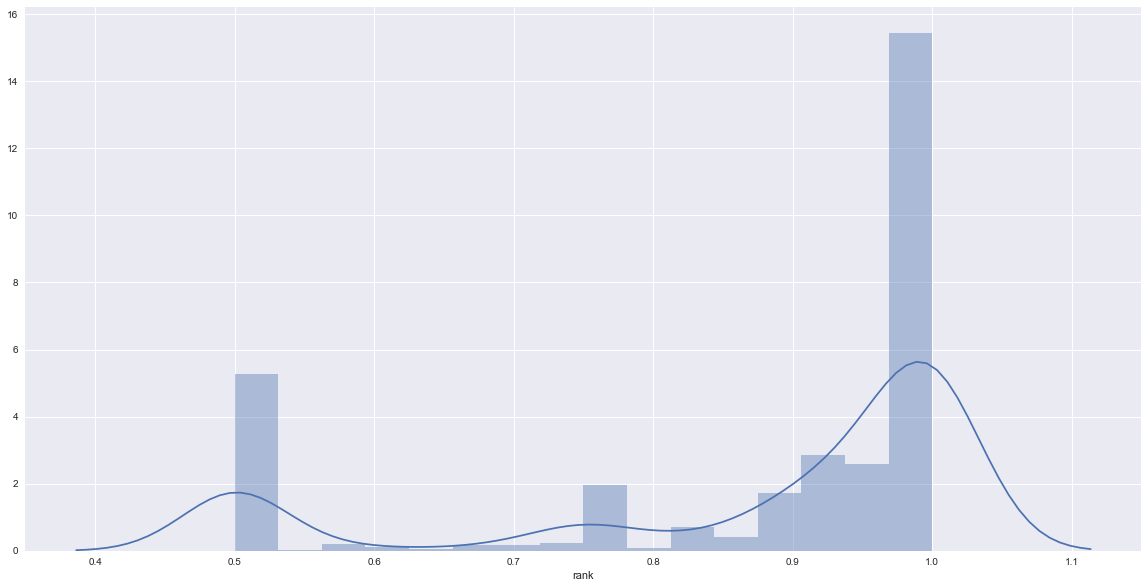

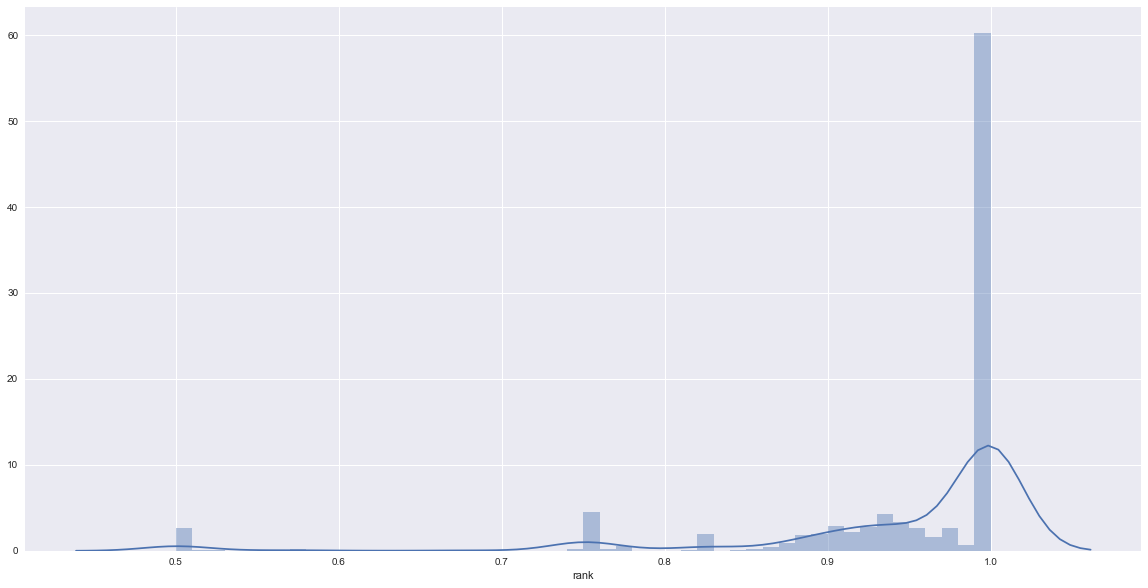

In [481]:
plt.figure(figsize=(20,10))
sns.distplot(d1['rank'].astype(float))
sns.plt.show()
plt.figure(figsize=(20,10))
sns.distplot(d2['rank'].astype(float))
sns.plt.show()

In [483]:
doremus_dbpedia_filtered_0_7 =doremus_dbpedia_filtered[doremus_dbpedia_filtered['rank'].astype(float)>=0.7]
len(doremus_dbpedia_filtered_0_7)

5426

<div class="alert alert-success">
The distribution seems similar; however to be very sure about the quality of our matching we can filter out the matchings with score lower than 0.7 rather than 0.5. However,doing like this, there is the risk to filer out some good matchings. So this is a tradeoff and it's necessary to choose between having 5426 matchings with really low percentage of error or 6023 matchings with more chanches of errors.
<br>
To find the paths between POIs and Dbpedia resources we'll select the 0.5 as threshold, because we are always in time to filter out at the end.
</div>